In [1]:
import pandas as pd               # to read in the synapse data
import numpy as np                # for numerical data
import matplotlib.pyplot as plt   # for plotting
import os                         # for OS specific operations such as directory/file manipulations
from collections import Counter
import import_ipynb as ipy
import csv
from matplotlib import cm
from annotationframeworkclient import FrameworkClient

#df = client.materialize.query_table("synapses_nt_v1", filter_in_dict = {"pre_pt_root_id": neur array, "post_pt_root_id": neur_array})

In [2]:
datastack_name = "flywire_fafb_production"
client = FrameworkClient(datastack_name)

In [3]:
client.annotation.get_tables()

versions = client.materialize.get_versions()
print(versions)

recent_version_info = client.materialize.get_version_metadata(versions[-1])
print(recent_version_info)

https://prod.flywire-daf.com/annotation/api/v2/aligned_volume/fafb_seung_alignment_v0/table
[48, 15, 16, 17, 18, 19, 20, 22, 26, 27, 29, 30, 31, 32, 34, 36, 49, 37, 50, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
{'expires_on': '2021-05-11T08:10:00.267088', 'valid': True, 'datastack': 'flywire_fafb_production', 'time_stamp': '2021-05-09T08:10:00.267088', 'id': 35, 'version': 47}


In [4]:
#Reads xmin, xmax, ymin, ymax, zmin, zmax and converts them from pixels to nanometers

region_parameters = {}

region_file = pd.read_csv('C:/Users/dusti/OneDrive/Desktop/Sung Soo Kim Research/New Synapse Coding Stuff/Readable/Regions.csv')

for i in range(len(region_file)):
    TempDict = {}
    
    for j in region_file:
        if j != "Region":
            if j == "zmin" or j == "zmax":
                TempDict[j] = int(region_file[j][i])*40
            else:
                TempDict[j] = int(region_file[j][i])*4
    
    CurrentReg = region_file["Region"][i]
    region_parameters[CurrentReg] = TempDict
    

    

In [5]:
def Filter_df(df, Region, Autapses = False, connection_score = 0, cleft_score = 0, min_dist = [120, 120, 120]):
    """
    Limits a df to various parameters.
    
    
    Parameters
    -------------
    df (pd df): A df based on synapse data given by client.materialize.query_table()
    Region (str): A region that is a key in the dict region_parameters
    Autapses (bool): False if you do not want autapses in the df (default)
    connection_score (int): The minimum connection score you want counted
    cleft_score (int): The minimum cleft score you want counted
    min_dist (list): The minimum distance between neurons in order to be considered different from each other.
    
    
    Returns
    -------------
    A pd df limited to the given region.
    
    
    """
    
    
    Lim_df = df
    
    
    RegDict = region_parameters[Region]
    Min_Values = [RegDict["xmin"], RegDict["ymin"], RegDict["zmin"]]
    Max_Values = [RegDict["xmax"], RegDict["ymax"], RegDict["zmax"]]
    
    Coord_Arrs = Lim_df["pre_pt_position"]
    Counter_Arr = np.zeros(len(Coord_Arrs), dtype = np.uint64)
    for i in range(len(Coord_Arrs)):
        for j in range(len(Coord_Arrs[i])):
            if Coord_Arrs[i][j] > Min_Values[j] and Coord_Arrs[i][j] < Max_Values[j]:
                Counter_Arr[i] += 1
    
    Lim_df["Temp_Arr"] = Counter_Arr
    Lim_df = Lim_df[Lim_df["Temp_Arr"] == 3]
    Lim_df.drop("Temp_Arr", axis = 1, inplace = True)
    
    
    if not Autapses:
        Lim_df = Lim_df[Lim_df["pre_pt_root_id"] != Lim_df["post_pt_root_id"]]
    
    
    Lim_df = Lim_df[Lim_df["connection_score"] >= connection_score]
    Lim_df = Lim_df[Lim_df["cleft_score"] >= cleft_score]
    
    
    
    
    Coords = Lim_df["pre_pt_position"]
    Pre_Partner = list(Lim_df["pre_pt_root_id"])
    Post_Partner = list(Lim_df["post_pt_root_id"])
    
    x_list = []
    y_list = []
    z_list = []
    coord_list = []

    for i in Coords:
        x_list.append(i[0])
        y_list.append(i[1])
        z_list.append(i[2])

    id_bools = [True] * len(x_list)
    
    bad_coords = []
    for i in range(len(x_list)):
        skip_loop = False
        for j in bad_coords:
            if i == j:
                skip_loop = True
                continue
        if skip_loop:
            continue
        for j in range(i+1, len(x_list)):
            if abs(x_list[i] - x_list[j]) < min_dist[0]:
                if abs(y_list[i] - y_list[j]) < min_dist[1]:
                    if abs(z_list[i] - z_list[j]) < min_dist[2]:
                        if Pre_Partner[i] == Pre_Partner[j]:
                            if Post_Partner[i] == Post_Partner[j]:
                                bad_coords.append(j)
       
    for i in bad_coords:
        id_bools[i] = False
    
    Lim_df = Lim_df[id_bools]
    
    
    
    
    return Lim_df
    
    
    

In [6]:
def in_version(ID, Region = "connectome"): #Enter a neuron ID, returns True or False whether that ID is in the spreadsheet
    """
    To test whether a given ID is in the spreadsheet or not.
    
    
    Parameters
    -------------
    ID (str/int): An ID to test.
    
    
    Returns
    -------------
    False if not in region.
    True if in region.
    
    
    """
    
    pre_df = client.materialize.query_table("synapses_nt_v1", filter_in_dict = {"post_pt_root_id": [ID]})
    post_df = client.materialize.query_table("synapses_nt_v1", filter_in_dict = {"pre_pt_root_id": [ID]})
    
    if pre_df.empty and post_df.empty:
        return False
    else:
        return True

    
    

In [7]:
def array_neurons(Neurons, Test = True):
    """
    Converts a long string of neurons into an array and prints which are not in the dataset.
    
    
    Parameters
    --------------
    Neurons (str): An inputted list of neuron IDs separated by commas.
    Test (bool): Tests whether the neurons are in the spreadsheet or not.
        If True: Removes all neurons that are not in the spreadsheet and informs you of them.
        If False: Keeps all neurons in the final array.
    
    
    Returns
    --------------
    The inputted neurons (that are in the dataset) in a numpy array.
    
    
    --------------
    """
    
    Neurons_array = np.array([x.strip() for x in Neurons.split(",")], dtype = np.uint64)
    
    if Test:
        not_in_spread = ""
        not_in_spread_index = []
        counter = 0

        for i in Neurons_array:
            if not in_version(i):
                if not_in_spread == "":
                    not_in_spread = str(i)
                else:
                    not_in_spread = not_in_spread + "," + str(i)
                not_in_spread_index.append(counter)
            counter += 1

        Neurons_array = np.delete(Neurons_array, not_in_spread_index)

        if not_in_spread_index:
            print("")
            print("These neurons are not in the dataset: ")
            print(not_in_spread)
            print("")
    
    return Neurons_array



In [8]:
def dict_partners(Neurons, PrePost, Region, min_syn_partners = 1):
    """
    Returns a dict of all partners of a given neuron and how many synapses are between them.
    
    
    Parameters
    -------------
    Neurons (str): A list of neuron IDs.
    PrePost: "pre" or "post". The position in which partners you want.
        If "pre": Gives all presynaptic partners to ID. ID is in "post_pt_root_id".
        If "post": Gives all postsynaptic partners to ID. ID is in "pre_pt_root_id".    
    Region (str): A specified region.
    min_syn_partners (int): The minimum number of synaptic connections you want for a partner to be included.
    
    
    Returns
    -------------
    A dict.
        Keys (int): Neuron ID.
        Values (int): The number of synaptic connections between ID and the Key.
        
        
    Prerequisites
    -------------
    array_neurons (function)
    iterate_syn (function)
    LimRegion (function)
    region_parameters (dict)
    
    
    -------------
    """
    
    neur_array = array_neurons(Neurons)
        
    if PrePost == "pre":
        df = client.materialize.query_table("synapses_nt_v1", filter_in_dict = {"post_pt_root_id": neur_array})
        df = Filter_df(df, Region)
        listed = list(df["pre_pt_root_id"])
    elif PrePost == "post":
        df = client.materialize.query_table("synapses_nt_v1", filter_in_dict = {"pre_pt_root_id": neur_array})
        df = Filter_df(df, Region)
        listed = list(df["post_pt_root_id"])
    else:
        return 'Please enter "pre" or "post" for PrePost'
    
    listed_unique = list(set(listed))
    remove_neurons = []

    for i in listed_unique:
        if listed.count(i) < min_syn_partners:
            remove_neurons.append(i)
    
    for i in remove_neurons:
        while i in listed:
            listed.remove(i)
    
    ordered = Counter(listed)
    ordered = dict(sorted(ordered.items(), key = lambda x: x[1], reverse = True))
    
    return ordered



In [9]:
def extract_connectome(PrePartners, PostPartners, Region):
    """
    Makes a numpy array of number of synapses between PrePartners and PostPartners.
    
    
    Parameters
    -------------
    PrePartners (str): All the presynaptic neurons, will create the rows, will go through array_neurons.
    PostPartners (str): All the postsynaptic neurons, will create the columns, will go through array_neurons.
    Region: The region the synapses are limited to.
    
    
    Returns
    -------------
    An array with the synapses between the PrePartners and PostPartners.
    
    
    Prerequisites
    -------------
    array_neurons (function)
    dict_partners (function)
    
    
    """
    
    
    Pre_Array = array_neurons(PrePartners)
    Post_Array = array_neurons(PostPartners)
    
    m = Pre_Array.size
    n = Post_Array.size
    
    syn_map = np.zeros((m,n), dtype = np.uint64)
    print("Number of presynaptic neurons: ", m)
    print("Number of postsynaptic neurons: ", n)
    print("========================================")

    for i in range(0, m):
        Current_Pre_Partners = dict_partners(str(Pre_Array[i]), "post", Region)
        
        for j in range(0,n):
            if Post_Array[j] in Current_Pre_Partners:
                syn_map[i,j] = Current_Pre_Partners[Post_Array[j]]
    
    return syn_map
    
    

In [10]:
def plot_connectivity(pre_keys, post_keys, Region, Graph_Name = "Synaptic Connections", binarizing_threshold=5):
    """
    Plots the number of synapses between pre and post neurons.
    
    
    Parameters
    --------------
    pre_keys (np array): An array in which each value is a string which is a key in syn_dict_dnu. Will be the types of neurons analyzed as presynaptic.
    post_keys (np array): An array in which each value is a string which is a key in syn_dict_dnu. Will be the types of neurons analyzed as postsynaptic.
    Region (str): The region to which the plot will be limited.
    Graph_Name (str): The title of the graph.
    binarizing_threshold (int): Not 100% sure.
    
    
    Returns
    --------------
    A figure plotting the number of synapses between pre and post neurons.
    
    
    
    Prerequisites
    --------------
    array_neurons (function)
    extract_connectome (function)
    
    
    """
    pre_ns = np.zeros(pre_keys.size, dtype = int)
    pre_label_position = np.zeros(2*pre_keys.size, dtype = float)
    pre_neurons = ""
    pre_label_list = np.array([], dtype = str)
    
    for i in range(pre_keys.size):
        current_type = pre_keys[i]
        current_neur_array = array_neurons(syn_dict_dnu[current_type])
        pre_ns[i] = current_neur_array.size
        pre_label_position[2*i] = sum(pre_ns) - pre_ns[i] - 0.5
        pre_label_position[2*i + 1] = sum(pre_ns) - pre_ns[i]/2 - 0.5
        if i == 0:
            pre_neurons = pre_neurons + syn_dict_dnu[current_type]
        else:
            pre_neurons = pre_neurons + "," + syn_dict_dnu[current_type]
        pre_label_list = np.concatenate([pre_label_list,['–––––––––––', current_type]])
    pre_label_position = np.concatenate([pre_label_position, [sum(pre_ns) - 0.5]])
    pre_label_list = np.concatenate([pre_label_list, ['–––––––––––']])
    
    post_ns = np.zeros(post_keys.size, dtype = int)
    post_label_position = np.zeros(2*post_keys.size, dtype = float)
    post_neurons = ""
    post_label_list = np.array([], dtype = str)
    
    for i in range(post_keys.size):
        current_type = post_keys[i]
        current_neur_array = array_neurons(syn_dict_dnu[current_type])
        post_ns[i] = current_neur_array.size
        post_label_position[2*i] = sum(post_ns) - post_ns[i] - 0.5
        post_label_position[2*i + 1] = sum(post_ns) - post_ns[i]/2 - 0.5
        if i == 0:
            post_neurons = post_neurons + syn_dict_dnu[current_type]
        else:
            post_neurons = post_neurons + "," + syn_dict_dnu[current_type]        
        post_label_list = np.concatenate([post_label_list,['–––––––––––', current_type]])
    post_label_position = np.concatenate([post_label_position, [sum(post_ns) - 0.5]])
    post_label_list = np.concatenate([post_label_list, ['–––––––––––']])
    
    synapses_array = extract_connectome(pre_neurons, post_neurons, Region)
    
    for p in range(2):
        separator = ', ' 
        tstr = separator.join(pre_keys) #joins the type names with comma and space
        
        # If the title string is too long, then the file name may generate an error
        if len(tstr)>100:
            tstr = tstr[0:100]
        if p==0: # plot the original
            title_str = tstr
        else:    # plot the binarized version
            synapses_array[synapses_array<binarizing_threshold] = 0
            synapses_array[synapses_array>=binarizing_threshold] = 1
            title_str = tstr + ' (binarized)'

        # Draw a figure
        figA = plt.figure(figsize = (15,15))
        ax1 = figA.add_subplot(1,1,1)
        img = ax1.imshow(synapses_array, cmap = plt.get_cmap("Purples"), interpolation='none')
        figA.colorbar(img, ax=ax1)

        ax1.set_title(Graph_Name)

        ax1.set_xlabel('Post-Synaptic Neurons')
        ax1.set_xticks(post_label_position)
        ax1.set_xticklabels(post_label_list,rotation=90)
        #ax1.set_xticklabels(label_list)

        ax1.set_ylabel('Pre-Synaptic Neurons')
        ax1.set_yticks(pre_label_position)
        ax1.set_yticklabels(pre_label_list)

        plt.show()

        figA.savefig(
                os.path.join('figures', title_str + '.png'), format='png',  # PNG plot keeps the resolution but the font is distorted. PDF is opposite.
                bbox_inches='tight',
                #transparent=True,
                pad_inches=0.1,
                dpi=150 # For publication, use higher dpi
            ) 


    
    return figA
    
    
    


# Takes a while (only run if making connectivity charts).

In [40]:
"""For importing neuron types from txt file"""


import time
start_time = time.time()


syn_dict_dnu = {}

with open('C:/Users/dusti/OneDrive/Desktop/Sung Soo Kim Research/New Synapse Coding Stuff/Readable/Neuron IDs.txt' , 'r', encoding = "utf8") as f:
    
    lines = f.readlines() #lines: list, each index is a line of text
    
    for i in range(len(lines)):
        
        if lines[i] == "Neuron Type:\n":
            types = [x.strip() for x in lines[i+1].split(",")]
            
            neurons = lines[i+2].strip()
            print("")
            print(types)
            if not neurons == "":
                array_neurons(neurons)
            
            for j in types:
                if not j in syn_dict_dnu:
                    syn_dict_dnu[j] = neurons
                else:
                    syn_dict_dnu[j] = syn_dict_dnu[j] + "," + neurons


print(syn_dict_dnu)

print("My program took", time.time() - start_time, "to run")





['MeTu_pl_l']


C:\Users\dusti\anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.



['MeTu_pl_r']

['MeTu_R2c_l']

['MeTu_R2c_r']

['MeTu_R2abd_l']

['MeTu_R2abd_r']

['MeTu_R3w_spiky_l']

['MeTu_R3w_spiky_r']

['MeTu_R3w_flat_l']

['MeTu_R3w_flat_r']

['MeTu_a_l']

['MeTu_pc_l']

['MeTu_pc_r']

['MeTu_m_l']

['TuBu_R4d_l']

['TuBu_R4d_r']

['TuBu_R2c_l']

['TuBu_R2c_r']

['TuBu_R2abd_l']

['TuBu_R2abd_r']

['TuBu_R3w_l']

['TuBu_R3w_r']

['TuBu_R5_l']

['TuBu_R5_r']

['TuBu_R4m_l']

['TuBu_R4m_r']

['R4d_l']

['R4d_r']

These neurons are not in the dataset: 
720575940620441558,720575940622143741


['R2c_l']

['R2c_r']

['R2abd_l']

['R2abd_r']

['R3w_l']

['R3w_r']

['R5_l']

['R5_r']

['R4m_l']

['R4m_r']

['TuTu_a_l', 'TuTu_a', 'TuTu']

['TuTu_a_r', 'TuTu_a', 'TuTu']

['TuTu_pc_l', 'TuTu_pc', 'TuTu']

['TuTu_pc_r', 'TuTu_pc', 'TuTu']

['TuBuBuTu_l', 'TuBuBuTu']

['TuBuBuTu_r', 'TuBuBuTu']

['EPG_1_l', 'EPG_l5', 'EPG_1', 'EPG']

['EPG_1_r', 'EPG_r5', 'EPG_1', 'EPG']

['EPG_2_l', 'EPG_l6', 'EPG_2', 'EPG']

['EPG_2_r', 'EPG_r4', 'EPG_2', 'EPG']

['EPG_3_l', 'EPG_l7',

# Below are all of the different things you can do.


In [12]:
"""
Enter a long list of neurons in and see which are in the spreadsheet and which aren't.
"""

All_Neurons = input("Please enter neuron(s): ")
All_Neurons = array_neurons(All_Neurons, Test = False)

in_spread = ""
not_in_spread = ""
count1 = 0
count2 = 0

for i in All_Neurons:
    if in_version(i):
        if in_spread == "":
            in_spread = str(i)
        else:
            in_spread = in_spread + "," + str(i)
        count1 += 1
    else:
        if not_in_spread == "":
            not_in_spread = str(i)
        else:
            not_in_spread = not_in_spread + "," + str(i)
        count2 += 1


print("")
print("These neurons are in the spreadsheet: ")
print(in_spread)
print("There are " + str(count1) + " neurons.")
print("")
print("These neurons are not in the spreadsheet: ")
print(not_in_spread)
print("There are " + str(count1 + count2) + " total neurons.")




Please enter neuron(s): 720575940634110606,720575940629044778,720575940623877680,720575940618425510,720575940615733794,720575940639473115,720575940626362667,720575940632187799,720575940635759332,720575940623580965,720575940617800212


C:\Users\dusti\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  
C:\Users\dusti\anaconda3\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  



These neurons are in the spreadsheet: 
720575940634110606,720575940629044778,720575940623877680,720575940618425510,720575940615733794,720575940639473115,720575940626362667,720575940632187799,720575940635759332,720575940623580965,720575940617800212
There are 11 neurons.

These neurons are not in the spreadsheet: 

There are 11 total neurons.


In [13]:
"""
Enter neuron(s) and find their partners.
"""

neurs = input("Please enter neurons: ")
Region = input("What region? ")
PrePost = input("Would you like pre or post partners? ")

partners = dict_partners(neurs, PrePost, Region, min_syn_partners = 5)
print("")
print(partners)
print("")    
print(list(partners.keys()))




Please enter neurons: 720575940631301587
What region? AOTu_l
Would you like pre or post partners? pre


C:\Users\dusti\anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.



{720575940612332182: 17, 720575940623299661: 16, 720575940604936834: 12, 720575940637936256: 11, 720575940626228042: 11, 720575940632216215: 7, 720575940610084570: 6}

[720575940612332182, 720575940623299661, 720575940604936834, 720575940637936256, 720575940626228042, 720575940632216215, 720575940610084570]


C:\Users\dusti\anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.
  if __name__ == '__main__':


In [96]:
"""
Make a synaptic map and export it to excel.
"""

Pre = input("Pre partners: ")
Post = input("Post partners: ")
Region = input("Please enter the region: ")

excel_maybe = input("Export to excel? (yes or no): ")
if excel_maybe == "yes":
    name = input("Name of File: ")

Map = extract_connectome(Pre, Post, Region)
print(Map)

if excel_maybe == "yes":
    excel = pd.DataFrame(data = Map)
    out_path = 'C:/Users/dusti/OneDrive/Desktop/Sung Soo Kim Research/New Synapse Coding Stuff/Spreadsheets/' + name + '.xlsx'
    excel.to_excel(out_path)




Pre partners: 720575940617959515
Post partners: 720575940623877680
Please enter the region: AOTu_l
Export to excel? (yes or no): no


C:\Users\dusti\anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.


Number of presynaptic neurons:  1
Number of postsynaptic neurons:  1


C:\Users\dusti\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.


[[4]]


Pre partner types: MeTu_pl_l
Post partner types: TuBu_R5_l, TuBu_R4m_l
Please enter the region: AOTu_l


C:\Users\dusti\anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.


Number of presynaptic neurons:  111
Number of postsynaptic neurons:  9


C:\Users\dusti\anaconda3\lib\site-packages\ipykernel_launcher.py:39: DeprecationWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.


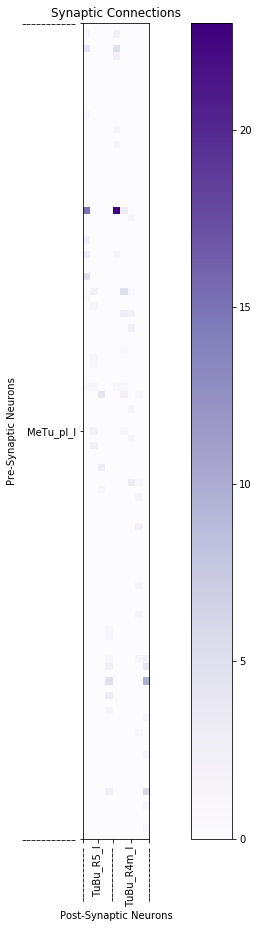

FileNotFoundError: [Errno 2] No such file or directory: 'figures\\MeTu_pl_l.png'

In [41]:
"""
Make a synaptic plot.
"""

Pre_Types = input("Pre partner types: ")
Post_Types = input("Post partner types: ")
Pre = np.array([x.strip() for x in Pre_Types.split(",")], dtype = str)
Post = np.array([x.strip() for x in Post_Types.split(",")], dtype = str)

Region = input("Please enter the region: ")

Map = plot_connectivity(Pre, Post, Region)
print(Map)




In [57]:
"""
Ranks the likelihoods of neurotransmitters used by a neuron.
"""
ID = input("Please enter neuron: ")
syn_df = client.materialize.query_table("synapses_nt_v1", filter_in_dict = {"pre_pt_root_id": [ID]})

Region = input("Please enter region: ")
syn_df = Filter_df(syn_df, Region)

nt_dict = {}

NTs = ["gaba", "ach", "glut", "oct", "ser", "da"]

for i in NTs:
    nt_dict[i] = sum(list(syn_df[i]))/len(syn_df[i])

ordered = sorted(nt_dict.items(), key = lambda x: x[1], reverse = True)
print(ordered)




Please enter neuron: 720575940615751970
Please enter region: Me_l
[('gaba', 0.4520406596395101), ('glut', 0.22091690730466176), ('ach', 0.16213097099192986), ('da', 0.10484533916902197), ('ser', 0.04161989321675789), ('oct', 0.018446223072089922)]


In [29]:
"""
Makes a csv file of all of the synapses between presynaptic and postsynaptic partners.
"""
Pre = input("Please enter presynaptic partner(s): ")
Post = input("Please enter postsynaptic partner(s): ")
Region = input("Please enter region: ")
name = input("Please create a file name: ")

print("Pre: ")
Pre = array_neurons(Pre)
print("")
print("Post:")
Post = array_neurons(Post)
print("")

df = client.materialize.query_table("synapses_nt_v1", filter_in_dict = {"pre_pt_root_id": Pre, "post_pt_root_id": Post})
df = Filter_df(df, Region)

Temp_Coords = list(df["pre_pt_position"])
Coords = []
for i in Temp_Coords:
    Coords.append("(" + str(int(i[0]/4)) + ", " + str(int(i[1]/4)) + ", " + str(int(i[2]/40)) + ")")
    
count = list(range(1,len(Coords)+1))


out_path = 'C:/Users/dusti/OneDrive/Desktop/Sung Soo Kim Research/New Synapse Coding Stuff/Coordinates/' + name + '.csv'
head = ["Coordinate 1", "Coordinate 2", "Ellipsoid Dimensions", "Tags", "Description", "Segments IDs", "Parent ID", "Type", "ID"]


with open(out_path, "w", newline = "") as file:
    thewriter = csv.writer(file)

    thewriter.writerow(head)

    count = 1
    for j in range(len(Coords)):
        Rows = [Coords[j], "", "", "", count, "", "", "Point", ""]
        thewriter.writerow(Rows)

        count+=1
        
        
#720575940608371320
#720575940625755132




Please enter presynaptic partner(s): 720575940617800212
Please enter postsynaptic partner(s): 720575940602586336
Please enter region: Bu_l
Please create a file name: Seeing 2
Pre: 


C:\Users\dusti\anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: 'pyarrow.deserialize' is deprecated as of 2.0.0 and will be removed in a future version. Use pickle or the pyarrow IPC functionality instead.



Post:



In [28]:
order = [86,39,78,56,45,88,106,22,85,1,74,12,89,81,29,25,104,69,107,61,26,32,108,30,28,103,8,35,53,95,82,67,54,4,2,83,19,31,96,0,41,33,15,36,21,102,87,92,101,98,37,72,93,13,44,97,42,17,57,23,46,16,73,9,60,79,52,3,40,7,75,71,10,11,99,55,20,14,100,68,50,34,43,63,58,80,70,84,48,24,62,66,110,105,109,38,90,51,94,91,77,64,65,76,27,5,18,6,49,59,47]

old_neurs = [720575940618204180,720575940618857537,720575940626509673,720575940634401125,720575940647601785,720575940634313829,720575940628770575,720575940632155031,720575940621434807,720575940608726994,720575940628016348,720575940632462234,720575940620266828,720575940616059712,720575940621030694,720575940632121012,720575940630968531,720575940645228164,720575940624719768,720575940609659797,720575940620934340,720575940632248471,720575940625748988,720575940616557691,720575940636492614,720575940624491865,720575940622615444,720575940625935110,720575940643564596,720575940629345347,720575940622585639,720575940635365086,720575940629087530,720575940631484084,720575940634124430,720575940623786426,720575940628409595,720575940621032486,720575940607330372,720575940612572822,720575940633453966,720575940628275420,720575940611358673,720575940624036866,720575940612339350,720575940618471003,720575940617431125,720575940622739388,720575940640102452,720575940604467145,720575940625656552,720575940628798738,720575940618877556,720575940618281862,720575940619809961,720575940630968787,720575940609660053,720575940624663370,720575940630231716,720575940633072747,720575940612340630,720575940633185972,720575940608371320,720575940637491584,720575940608726482,720575940620797183,720575940635291358,720575940630943955,720575940628841487,720575940620553229,720575940607330628,720575940607343684,720575940611578163,720575940635519972,720575940618060971,720575940619778565,720575940620946019,720575940642623268,720575940618134292,720575940609983411,720575940615762205,720575940620845069,720575940643564852,720575940615300898,720575940624322905,720575940624323161,720575940609938418,720575940621813768,720575940637095283,720575940612405502,720575940620751053,720575940605093810,720575940624652602,720575940613606342,720575940619908129,720575940637095027,720575940624652346,720575940633452430,720575940612260242,720575940612339606,720575940619661150,720575940621183487,720575940641612232,720575940619810217,720575940609446769,720575940612343714,720575940632785818,720575940615658530,720575940610216089,720575940626605571,720575940615294932]

new_neurs = [old_neurs[i] for i in order]

print(new_neurs)




[720575940609938418, 720575940612572822, 720575940618134292, 720575940609660053, 720575940618471003, 720575940637095283, 720575940632785818, 720575940625748988, 720575940624323161, 720575940618857537, 720575940618060971, 720575940620266828, 720575940612405502, 720575940620845069, 720575940629345347, 720575940624491865, 720575940609446769, 720575940620553229, 720575940615658530, 720575940633185972, 720575940622615444, 720575940629087530, 720575940610216089, 720575940622585639, 720575940643564596, 720575940619810217, 720575940621434807, 720575940623786426, 720575940618281862, 720575940637095027, 720575940643564852, 720575940630943955, 720575940619809961, 720575940647601785, 720575940626509673, 720575940615300898, 720575940609659797, 720575940635365086, 720575940624652346, 720575940618204180, 720575940628275420, 720575940631484084, 720575940632121012, 720575940628409595, 720575940632248471, 720575940641612232, 720575940621813768, 720575940624652602, 720575940621183487, 720575940612260242,